# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

---
# Setup Data

## Load & Display Data
[Kaggle Dataset](https://www.kaggle.com/ntnu-testimon/paysim1 "Synthetic Financial Datasets For Fraud Detection")

In [2]:
df = pd.read_csv('data/card.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Check Value Type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Define Each Feature

### We have 11 initial features:

* **step:** Maps a unit of time in the real world. In this case 1 step is 1 hour of time.
* **type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
* **amount:** amount of the transaction in local currency
* **nameOrig:** customer who started the transaction
* **oldbalanceOrg:** initial balance before the transaction
* **newbalanceOrig:** customer's balance after the transaction.
* **nameDest:** recipient ID of the transaction.
* **oldbalanceDest:** initial recipient balance before the transaction.
* **newbalanceDest:** recipient's balance after the transaction.
* **isFraud:** identifies a fraudulent transaction (1) and non fraudulent (0)
* **isFlaggedFraud:** flags illegal attempts to transfer more than 200.000 in a single transaction.

---
# Clear Data

## Check for Null

### since the data is synthetic there are no null values
#### (as shown bellow)

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Understand The Data

### Check Transaction Types

In [5]:
df['step'].unique()[-5:]

array([739, 740, 741, 742, 743], dtype=int64)

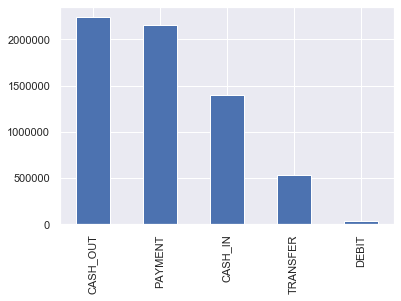

In [6]:
df['type'].value_counts().plot.bar()
plt.show()

In [7]:
precent = df['type'].value_counts(normalize=True)['DEBIT']*100
lines = df[df['type'] == 'DEBIT']['type'].value_counts()['DEBIT']
print("The precent of DEBIT in the Data Set is {:.2f}% ({} lines)".format(precent, lines))

The precent of DEBIT in the Data Set is 0.65% (41432 lines)


In [8]:
len(df['nameOrig'].unique())

6353307

## Own Predictions

In [9]:
"{:.2f}%".format(df['isFraud'].value_counts(normalize=True)[1]*100)

'0.13%'

### 1. Fraud is only in: TRANSFER, CASH OUT
#### (at about the same amount)

In [48]:
fraud = df[df['isFraud'] == 1]
fraud['type'].value_counts(normalize=True)*100

CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64

### 2. Precentage of Transfer Fraud is about 0.77%

In [13]:
df[df['type'] == 'TRANSFER']['isFraud'].value_counts(normalize=True)[1]*100

0.7687991758442811

### 3. Precentage of Cash Out Fraud is about 0.18%

In [14]:
df[df['type'] == 'CASH_OUT']['isFraud'].value_counts(normalize=True)[1]*100

0.18395530726256984

### 4. If The Transaction Amount Was The Same As The Balance: Its Fraud

In [31]:
df[df['amount'] == df['oldbalanceOrg']]['isFraud'].unique()

array([1], dtype=int64)

### 5. If the Existing Fraud Detection Flags the Transaction as Fraud, It's Fraud

In [46]:
df[df['isFlaggedFraud'] == 1]['isFraud'].unique()

array([1], dtype=int64)

In [32]:
df[df['amount'] == df['oldbalanceOrg']]['isFlaggedFraud'].unique()

array([0, 1], dtype=int64)

In [43]:
tmp = df[df['amount'] == df['oldbalanceOrg']]['isFlaggedFraud']
df[df['amount'] == df['oldbalanceOrg']][tmp==1].head()
df[df['amount'] == df['oldbalanceOrg']][tmp==0].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [15]:
delta = df['oldbalanceOrg']-df['newbalanceOrig']
ndelta = delta[delta<0]
pdelta = delta[delta>=0]
print(len(ndelta))
print(len(pdelta))

1399253
4963367


In [20]:
debit = df[df['type'] == 'DEBIT']
debit.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0
21,1,DEBIT,9302.79,C1566511282,11299.0,1996.21,C1973538135,29832.0,16896.70,0,0
22,1,DEBIT,1065.41,C1959239586,1817.0,751.59,C515132998,10330.0,0.00,0,0
41,1,DEBIT,5758.59,C1466917878,32604.0,26845.41,C1297685781,209699.0,16997.22,0,0


In [21]:
debit['amount'].min()

0.55

In [22]:
debit['amount'].max()

569077.51

In [25]:
flaggedFraud = df[df['isFlaggedFraud'] == 1]
flaggedFraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1


In [30]:
df[df['amount'] > df['oldbalanceOrg']]['isFraud'].unique()

array([0, 1], dtype=int64)